In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
example_rock = '../calibration_images/example_rock1.jpg'
rock_img = mpimg.imread(example_rock)
plt.imshow(rock_img)


In [2]:
import numpy as np


class Pixel_Species:
    """This object is like a wildlife biologist tracking the population
    of and discovering new species.
    
    What it does is give the classificiation for a species
    within our total population of pixels. The classification is based on
    rgb values. 
    The rgb must be within a spread determined at first by a constant and later
    by a certain number of standard deviations.
    """
    
    def __init__(self):
        
        self.min_pixel = [0,0,0]
        self.max_pixel = [0,0,0]
        self.pixel_range = [self.min_pixel,self.max_pixel]
        self.population = 0
        self.members = []
        self.name = None
        self.spread = 25
        self.sigmas = 2
        
    def add_member(self,pixel):
        """Once we've determined that a member belongs within the species
        we can update our species info by adding one to the population
        and also having a better classifier for what kinds of animals are in
        this species anyway."""
        
        self.members.append(pixel)
        
        if self.population < 25:
    
            self.min_pixel = [pixel[0]-self.spread,pixel[1]-self.spread,pixel[2]-self.spread]
            self.max_pixel = [pixel[0]+self.spread,pixel[1]+self.spread,pixel[2]+self.spread]
            
            self.min_pixel = [0 if self.min_pixel[i] < 0 else self.min_pixel[i] for i in range(3)]
            self.max_pixel = [255 if self.max_pixel[i] > 255 else self.max_pixel[i] for i in range(3)]
                
            self.population += 1
            
        else:
            self.update_pixel_range()
            self.population += 1
            
        #print(self.min_pixel,self.max_pixel,pixel)
        
    def is_member(self,pixel):
        
        isMember =  all([self.min_pixel[i] < pixel[i] < self.max_pixel[i] for i in range(3)])
        return isMember
    
    def update_pixel_range(self):
        
        for member in self.members:
            members_numpy = np.array(self.members)
            std_x = np.std(members_numpy[:,0])
            std_y = np.std(members_numpy[:,1])
            std_z = np.std(members_numpy[:,2])
            avg_x = np.mean(members_numpy[:,0])
            avg_y = np.mean(members_numpy[:,1])
            avg_z = np.mean(members_numpy[:,2])
            
            self.min_pixel = np.around([avg_x-self.sigmas*std_x,avg_y-self.sigmas*std_y,avg_z-self.sigmas*std_z],0)
            self.max_pixel = np.around([avg_x+self.sigmas*std_x,avg_y+self.sigmas*std_y,avg_z+self.sigmas*std_z],0)
            
        self.min_pixel = [0 if self.min_pixel[i] < 0 else self.min_pixel[i] for i in range(3)]
        self.max_pixel = [255 if self.max_pixel[i] > 255 else self.max_pixel[i] for i in range(3)]
        
    
            
class Pixel_Kingdom:
    """
    This kingdom keeps track of all the species we find and allows us to operate on all of them simultaneously. 
    """
    def __init__(self,image_list):
        """We won't re-reference our pictures because creating that reference means reserving the memory space which
        I'd like to avoid since this code might be useful later."""
        
        self.species_number = 0
        self.species_dictionary = {}
        self.species_ever_number = 0
        self.pixel_list = self.list_format(image_list)
        self.classify_species(self.pixel_list)
        
    def classify_species(self,pixel_list):
        
        count = 0
        
        for pixel in pixel_list:

            added_to_existing_species = False

            for species in self.species_dictionary:
                if self.species_dictionary[species].is_member(pixel):
                    self.species_dictionary[species].add_member(pixel)
                    added_to_existing_species = True

            if not added_to_existing_species:
                new_species = Pixel_Species()
                new_species.add_member(pixel)
                self.add_species(new_species)
                
            count+=1
        
        self.simple_merge()
        self.clear_empty()
        self.kill_low_populations()
        self.merge_list()
        self.clear_empty()
        self.kill_low_populations()
            #print(count,added_to_existing_species,pixel)

        
    def add_species(self,new_species,species_name = "default"):
        
        if species_name == "default":
            new_species.name = "species_%s"%(self.species_ever_number+1)
        
        self.species_dictionary[new_species.name] = new_species
        self.species_number += 1
        self.species_ever_number += 1
        
    def delete_species(self,species_name):
        
        del self.species_dictionary[species_name]
        self.species_number -= 1
        
    def simple_merge(self):
        
        for species_1 in self.species_dictionary:
            for species_2 in self.species_dictionary:
                if species_1 != species_2 and (self.species_dictionary[species_1].min_pixel == self.species_dictionary[species_2].min_pixel) and (self.species_dictionary[species_1].max_pixel == self.species_dictionary[species_2].max_pixel):
                    
                    #print(self.species_dictionary[species_1].max_pixel,self.species_dictionary[species_2].max_pixel)
                    
                    self.species_dictionary[species_1].population += self.species_dictionary[species_2].population
                    self.species_dictionary[species_2].population = 0
                    
                    self.species_dictionary[species_1].members.append(self.species_dictionary[species_2].members)
                    self.species_dictionary[species_2].members = []
                    
                    self.species_dictionary[species_2].min_pixel = [0,0,0]
                    self.species_dictionary[species_2].max_pixel = [0,0,0]
                    
                    #print(self.species_dictionary[species_1].max_pixel,self.species_dictionary[species_2].max_pixel)
    def clear_empty(self):
        
        to_delete = []
        for species in self.species_dictionary:
            if self.species_dictionary[species].population == 0:
                to_delete.append(species)
                
        for species in to_delete:
            self.delete_species(species)
            
    def kill_low_populations(self):
        
        to_delete = []
        for species in self.species_dictionary:
            if self.species_dictionary[species].population < 10:
                to_delete.append(species)
                
        for species in to_delete:
            self.delete_species(species)
    
    def merge_list(self):
        
        delta = 20

        similar = []

        i = 0

        for species_1 in self.species_dictionary:

            i += 1

            lower_bound_min = np.array(self.species_dictionary[species_1].min_pixel)-delta
            upper_bound_min = np.array(self.species_dictionary[species_1].min_pixel)+delta
            lower_bound_max = np.array(self.species_dictionary[species_1].max_pixel)-delta
            upper_bound_max = np.array(self.species_dictionary[species_1].max_pixel)+delta

            j = 0

            for species_2 in self.species_dictionary:

                j += 1

                check_min = self.species_dictionary[species_2].min_pixel
                check_max = self.species_dictionary[species_2].max_pixel

                good = all([lower_bound_min[i] < check_min[i] < upper_bound_min[i] for i in range(3)]) and all([lower_bound_max[i] < check_max[i] < upper_bound_max[i] for i in range(3)])

                if good and j >= i and species_1:
                    similar.append([species_1,species_2,True])

        for i in range(len(similar)):
            for j in range(len(similar)):
                if similar[i][0] != similar[j][0] and similar[i][1] == similar[j][0]:
                    similar[j][2] = False

        for pair in similar:
            if pair[2] and (pair[0] != pair[1]):
                self.manual_merge(pair[0],pair[1])

        
    def manual_merge(self,species_1,species_2):
        
        self.species_dictionary[species_1].population += self.species_dictionary[species_2].population
        self.species_dictionary[species_2].population = 0
                    
        self.species_dictionary[species_1].members.append(self.species_dictionary[species_2].members)
        self.species_dictionary[species_2].members = []
        
        self.species_dictionary[species_1].min_pixel = min(self.species_dictionary[species_1].min_pixel,self.species_dictionary[species_2].min_pixel)
        self.species_dictionary[species_1].max_pixel = max(self.species_dictionary[species_1].max_pixel,self.species_dictionary[species_2].max_pixel)
                    
        self.species_dictionary[species_2].min_pixel = [0,0,0]
        self.species_dictionary[species_2].max_pixel = [0,0,0]
    
    def list_format(self,image_list):
        my_new_image_list = []
        for image in image_list:
            for column in image:
                for pixel in column:
                    my_new_image_list.append(pixel)
        return my_new_image_list

In [4]:
new_rock_img_1 = np.array(rock_img[100:102])
np.shape(new_rock_img_1)

kingdom = Pixel_Kingdom([new_rock_img_1])

kingdom.species_number

for species in kingdom.species_dictionary:
    print(species,kingdom.species_dictionary[species].population,kingdom.species_dictionary[species].min_pixel,np.round(kingdom.species_dictionary[species].max_pixel,1))

species_1 1865 [193.0, 172.0, 162.0] [204. 186. 175.]
species_8 83 [138.0, 109.0, 1.0] [156. 123.  22.]
species_15 57 [0, 0, 0] [45 38 28]
species_24 24 [172, 162, 153] [222 212 203]
species_25 30 [115, 90, 0] [165 140  39]


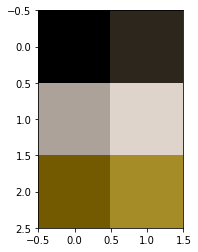

In [5]:
kingdom.manual_merge('species_25','species_8')
kingdom.manual_merge('species_24','species_1')
kingdom.clear_empty()

img = []
for species in kingdom.species_dictionary:
    spec = kingdom.species_dictionary[species]
    l = [int(i) for i in spec.min_pixel]
    h = [int(i) for i in spec.max_pixel]
    img.append([l,h])

plt.imshow(img)